In [1]:
import pommerman
from pommerman import agents, make
import torch
from torch.distributions import Categorical

print(pommerman.REGISTRY)

['PommeFFACompetition-v0', 'PommeFFACompetitionFast-v0', 'PommeFFAFast-v0', 'PommeFFA-v1', 'OneVsOne-v0', 'PommeRadioCompetition-v2', 'PommeRadio-v2', 'PommeTeamCompetition-v0', 'PommeTeamCompetitionFast-v0', 'PommeTeamCompetition-v1', 'PommeTeam-v0', 'PommeTeamFast-v0']


In [2]:
import inspect

inspect.getfullargspec(make)

FullArgSpec(args=['config_id', 'agent_list', 'game_state_file', 'render_mode'], varargs=None, varkw=None, defaults=(None, 'human'), kwonlyargs=[], kwonlydefaults=None, annotations={})

In [3]:
from utils.wrapper import ConservativeEnvWrapper
from pommerman.configs import one_vs_one_env

env_config = one_vs_one_env()
env_config['env_kwargs']['agent_view_size'] = 4
env = ConservativeEnvWrapper(env_config)

## How does the environment work?

\<class pommerman.envs.vo.Pomme\> --> self.model = \<class pommerman.forward_model.ForwardModel\>
\<class pommerman.envs.vo.Pomme\> --> 


In [4]:
from pommerman.envs.v0 import Pomme
#print(inspect.getsource(Pomme.reset))
#print(inspect.getsource(Pomme.get_observations))
#print(inspect.getsource(Pomme.__init__))

## observation
- The observation is given by the get_observations method from ForwardModel. (get_observations method in the v0.py calls the get_observation method in forward_model.py

- The environment returns observations of each agents

In [26]:
import random
from pommerman.agents.base_agent import BaseAgent
import torch
class CustomAgent(BaseAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def act(self):
        act_dist = Categorical(torch.Tensor(np.random.randint(2,10, size=(6,))))
        act_prob = act_dist.probs
        log_act_prob = torch.log(act_prob)
        action = act_dist.sample()
        return act_prob, log_act_prob, action

agent_list = [CustomAgent(env_config['agent'](0,env_config['game_type'])), agents.SimpleAgent(env_config['agent'](1,env_config['game_type']))]
env.set_agents(agent_list)
trainee_id = [0]
env.set_training_agents(*trainee_id)
env.set_init_game_state(None)
env._agents

In [6]:
obs = env.reset()

In [7]:
#obs
env._training_agents

[0]

In [8]:
actions = env.act(obs)
print(actions)

[3]


In [9]:
import random
import numpy as np
trainee_actions = []
for i in trainee_id[::-1]:
    act_prob, log_act_prob, action = env._agents[i].act()
    trainee_actions.append((act_prob, log_act_prob, action))
    actions.insert(0, action.item())
print(actions)
obs_, reward, done, info = env.step(actions)
import pprint
pprint.pprint([obs_, reward, done, info])

[4, 3]
[[{'additional': array([ 1.,  2.,  2.,  0.,  9.,  1., 11.,  0.]),
   'locational': array([[[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  0.,  2.,  0.,  0.,  1.,  1.,  2.],
        [ 1.,  1.,  2.,  0., 10.,  0.,  0.,  1.,  1.],
        [ 1.,  1.,  0.,  0.,  0.,  2.,  2.,  2.,  1.],
        [ 1.,  1.,  0.,  0.,  2.,  0.,  2.,  2.,  1.],
        [ 1.,  1.,  1.,  0.,  2.,  2.,  0.,  2.,  0.],
        [ 1.,  1.,  1.,  1.,  2.,  2.,  2.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,

In [10]:
env.render()

In [10]:
trainee_actions[0][0]

tensor([0.1739, 0.1304, 0.0870, 0.1304, 0.2174, 0.2609])

## set training agent
- by setting the traing agent (from 0, 1, 2, 3) (The agent id is the enumerated version of agents list

In [11]:
import torch
from torch.distributions import Categorical

act_prob = Categorical(torch.Tensor(np.random.randint(2,10, size=(6,))))
act_prob.probs

tensor([0.2258, 0.1935, 0.0645, 0.2258, 0.1613, 0.1290])

In [12]:
## Using ReplayBuffer
import numpy as np
from rl2.buffers.base import ReplayBuffer

buffer_kwargs = {
    'size' : 1e6,
    'elements' : {
        'obs':((5,9,9), (8,), np.float32),
        'action': ((6,), np.float32),
        'reward': ((1,), np.float32),
        'done': ((1,), bool),
        'obs_': ((5,9,9), (8,), np.float32)
    }
}

In [13]:
buffer = ReplayBuffer(**buffer_kwargs)
buffer.reset()

In [14]:
buffer[0]
buffer.keys
trainee_actions[0][0].unsqueeze(-1)

tensor([[0.1739],
        [0.1304],
        [0.0870],
        [0.1304],
        [0.2174],
        [0.2609]])

In [15]:
print(obs[0])
buffer_element = {'obs': obs[0],'action': trainee_actions[0][0], 'reward': reward[0],'done': done, 'obs_': obs_[0]}
buffer.push(**buffer_element)

{'locational': array([[[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  0.,  2.,  0.,  0.,  1.,  1.],
        [ 1.,  1.,  1.,  2., 10.,  0.,  0.,  0.,  1.],
        [ 1.,  1.,  1.,  0.,  0.,  0.,  2.,  2.,  2.],
        [ 1.,  1.,  1.,  0.,  0.,  2.,  0.,  2.,  2.],
        [ 1.,  1.,  1.,  1.,  0.,  2.,  2.,  0.,  2.],
        [ 1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,

In [16]:
buffer[0]

[{'locational': array([[[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  0.,  2.,  0.,  0.,  1.,  1.],
          [ 1.,  1.,  1.,  2., 10.,  0.,  0.,  0.,  1.],
          [ 1.,  1.,  1.,  0.,  0.,  0.,  2.,  2.,  2.],
          [ 1.,  1.,  1.,  0.,  0.,  2.,  0.,  2.,  2.],
          [ 1.,  1.,  1.,  1.,  0.,  2.,  2.,  0.,  2.],
          [ 1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  0.]],
  
         [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0

In [24]:
state = buffer[0][0]
def preprocessor(obs, keys = ['locational', 'additional']):
    return [obs[key] for key in keys]
loc, add = preprocessor(state)
pprint.pprint(loc)
pprint.pprint(add)

array([[[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  0.,  2.,  0.,  0.,  1.,  1.],
        [ 1.,  1.,  1.,  2., 10.,  0.,  0.,  0.,  1.],
        [ 1.,  1.,  1.,  0.,  0.,  0.,  2.,  2.,  2.],
        [ 1.,  1.,  1.,  0.,  0.,  2.,  0.,  2.,  2.],
        [ 1.,  1.,  1.,  1.,  0.,  2.,  2.,  0.,  2.],
        [ 1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

      

Text(0.5, 0, 'KL-divergence is the shaded area KL(G||R):   25.2')

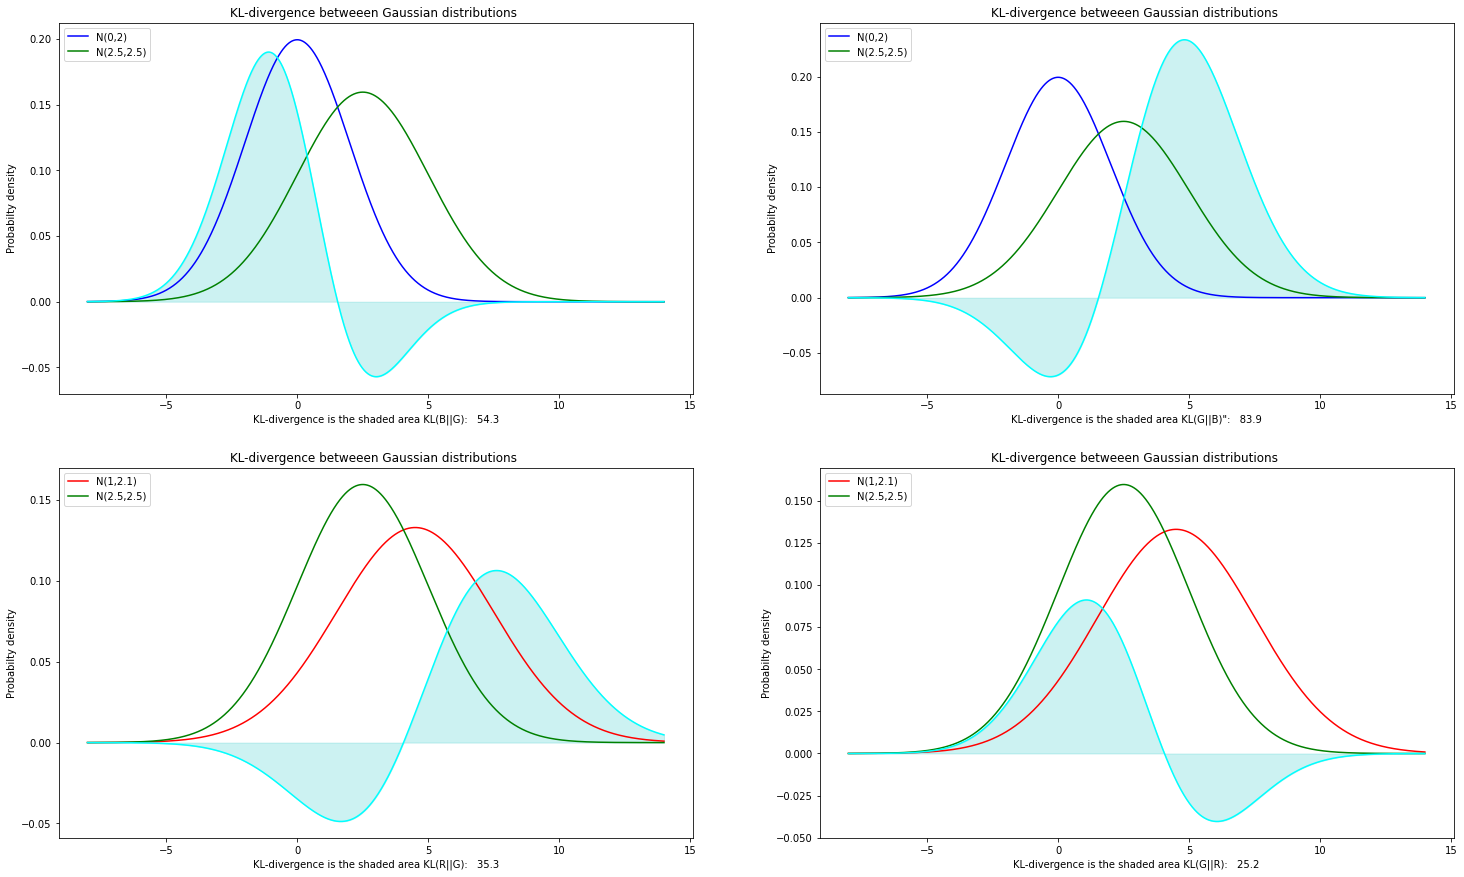

In [61]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

%matplotlib inline

def kl_divergence(p, q):    
    arr_kl = np.where(p != 0, p * np.log(p / q), 0)
    return arr_kl, np.sum(arr_kl)

fig = plt.figure(figsize=(25, 15))

x = np.arange(-8, 14, 0.01)
bl = norm.pdf(x, 0, 2)
gr = norm.pdf(x, 2.5, 2.5)
re = norm.pdf(x, 4.5, 3)

title = 'KL-divergence betweeen Gaussian distributions '
ylabel = 'Probabilty density'

ax1 = fig.add_subplot(221)
ax1.set_title(title)
ax1.plot(x, bl, 'blue', label = "N(0,2)")
ax1.plot(x, gr, 'green', label = "N(2.5,2.5)")
ax1.set_ylabel(ylabel)
array_blue_green, blue_green = kl_divergence(bl, gr) 
ax1.plot(x, array_blue_green, 'cyan')
ax1.legend(loc=2) 
ax1.fill_between(x, 0, array_blue_green, color='c',alpha=.2)
ax1.set_xlabel('KL-divergence is the shaded area KL(B||G):   %.1f' % blue_green)

ax2 = fig.add_subplot(222)
ax2.set_title(title)
ax2.plot(x, bl, 'blue', label = "N(0,2)")
ax2.plot(x, gr, 'green', label = "N(2.5,2.5)")
ax2.set_ylabel(ylabel)
array_green_blue, green_blue = kl_divergence(gr, bl) 
ax2.plot(x, array_green_blue, 'cyan')
ax2.legend(loc=2) 
ax2.fill_between(x, 0, array_green_blue, color='c',alpha=.2)
ax2.set_xlabel('KL-divergence is the shaded area KL(G||B)":   %.1f' % green_blue)

ax3 = fig.add_subplot(223)
ax3.set_title(title)
ax3.plot(x, re, 'red', label = "N(1,2.1)")
ax3.plot(x, gr, 'green', label = "N(2.5,2.5)")
ax3.set_ylabel(ylabel)
array_red_green, red_green = kl_divergence(re, gr) 
ax3.plot(x, array_red_green, 'cyan')
ax3.legend(loc=2) 
ax3.fill_between(x, 0, array_red_green, color='c',alpha=.2)
ax3.set_xlabel('KL-divergence is the shaded area KL(R||G):   %.1f' % red_green)

ax4 = fig.add_subplot(224)
ax4.set_title(title)
ax4.plot(x, re, 'red', label = "N(1,2.1)")
ax4.plot(x, gr, 'green', label = "N(2.5,2.5)")
ax4.set_ylabel(ylabel)
array_green_red, green_red = kl_divergence(gr, re) 
ax4.plot(x, array_green_red, 'cyan')
ax4.legend(loc=2) 
ax4.fill_between(x, 0, array_green_red, color='c',alpha=.2)
ax4.set_xlabel('KL-divergence is the shaded area KL(G||R):   %.1f' % green_red)


Text(0.5, 0, 'Dependence of KL(p||q) on standard deviation for q ')

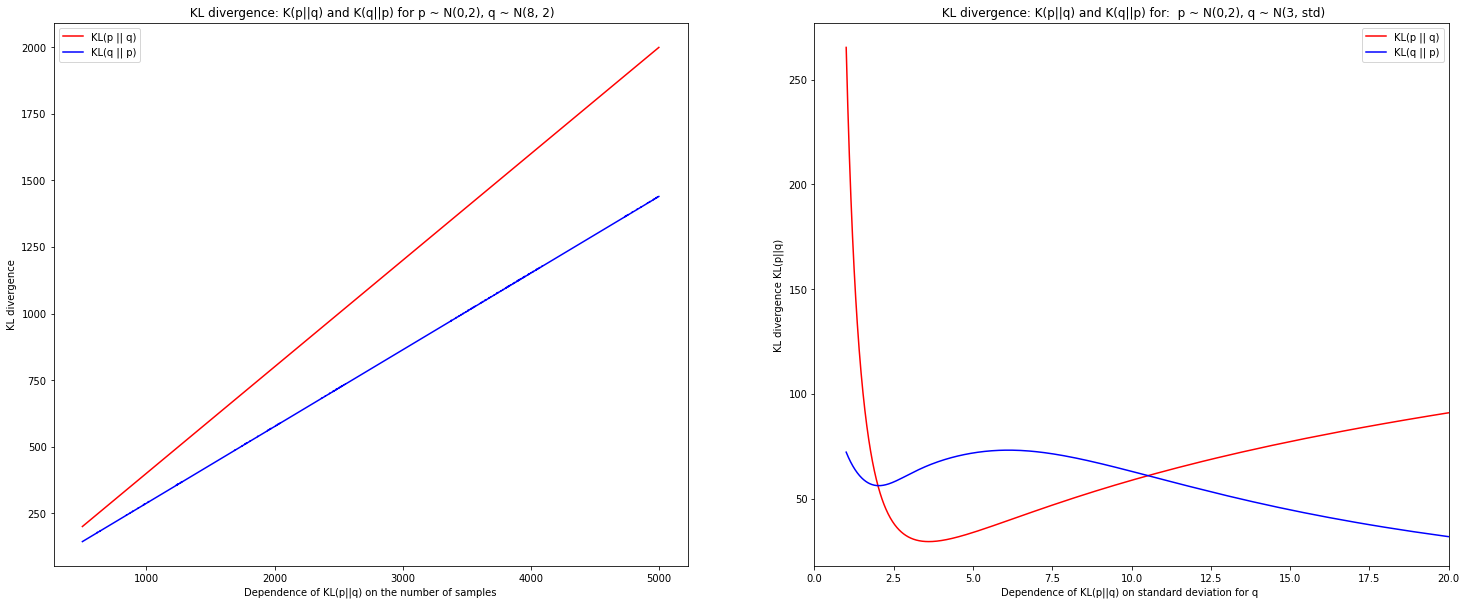

In [62]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

def kl_divergence(p, q):    
    arr_kl = np.where(p != 0, p * np.log(p / q), 0)
    return arr_kl, np.sum(arr_kl)

def calc_diverg_pq_and_qp(n_samples, mean, std):
   
   step = 20/n_samples
   
   x = np.arange(-10, 10, step)
   p = norm.pdf(x, 0, 2)
   q = norm.pdf(x, mean, std)

   _, diverg_pq = kl_divergence(p, q) 
   _, diverg_qp = kl_divergence(q, p) 
   
   return round(diverg_pq,3), round(diverg_qp,3)

def get_divergence_by_std():    
    l_diverg_pq = []
    l_diverg_qp = []
    l_std = []
    n_samples = 1000

    for i_std in range(100,2000):    
        mean = 3
        std = i_std*0.01
    
        kld_pq, kld_qp = \
            calc_diverg_pq_and_qp(n_samples, mean, std)
        l_diverg_pq.append(kld_pq)
        l_diverg_qp.append(kld_qp)
        l_std.append(std)
      
    return l_std, l_diverg_pq, l_diverg_qp    

def get_divergence_by_nsamples():    
    l_samples = []
    l_diverg_pq = []
    l_diverg_qp = []

    for n_samples in range(500,5000):    
        mean = 8
        std = 2 
    
        kld_pq, kld_qp = calc_diverg_pq_and_qp(n_samples, mean, std)
        l_diverg_pq.append(kld_pq)
        l_diverg_qp.append(kld_qp)
        l_samples.append(n_samples)
      
    return l_samples, l_diverg_pq, l_diverg_qp    

fig = plt.figure(figsize=(25, 10))

list_npoints, list_diverg_pq_2, list_diverg_qp_2 = get_divergence_by_nsamples()             
ax1 = fig.add_subplot(121)
ax1.set_title(' KL divergence: K(p||q) and K(q||p) for p ~ N(0,2), q ~ N(8, 2)')
ax1.plot(list_npoints, list_diverg_pq_2, 'red',   label = "KL(p || q)")
ax1.plot(list_npoints, list_diverg_qp_2, 'blue',  label = "KL(q || p)")
ax1.legend(loc=2) 
ax1.set_ylabel('KL divergence')
ax1.set_xlabel('Dependence of KL(p||q) on the number of samples')

list_std, list_diverg_pq_1, list_diverg_qp_1 = get_divergence_by_std()    
ax2 = fig.add_subplot(122)
ax2.set_title(' KL divergence: K(p||q) and K(q||p) for:  p ~ N(0,2), q ~ N(3, std)')
ax2.plot(list_std, list_diverg_pq_1, 'red',   label = "KL(p || q)")
ax2.plot(list_std, list_diverg_qp_1, 'blue',  label = "KL(q || p)")
ax2.set_xlim([0, 20])
ax2.legend(loc=1) 
ax2.set_ylabel('KL divergence KL(p||q)')
ax2.set_xlabel('Dependence of KL(p||q) on standard deviation for q ')